In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
import file_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


In [3]:
def get_missed_predictions(tourney_comp_ratings, model_features, prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [4]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [5]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()


season          school                               team_id  games    srs  \
0    2000       Air Force  aa7af640-5762-4686-9181-39f7b8a8186e     29  -3.57   
1    2000           Akron  56fe0ab2-e4f0-47b9-8726-9ce23ebcde20     28  -3.09   
2    2000         Alabama  c2104cdc-c83d-40d2-a3cd-df986e29f5d3     36  14.02   
3    2000     Alabama A&M  949c3398-85e4-4c63-ba71-9a82e06ddea4     28 -13.46   
4    2000  Alabama State   267d417a-8f85-4c87-a15a-068c089a74c6     31  -8.86   

     sos  win_pct  pts_avg  opp_pts_avg  fg_pct  ft_pct   poss_avg  \
0   1.99    0.276       57           63   0.435   0.697  63.020690   
1   1.67    0.429       67           72   0.452   0.725  73.857143   
2   6.27    0.694       76           68   0.433   0.698  86.200000   
3 -11.79    0.607       73           74   0.391   0.626  94.264286   
4 -13.61    0.710       68           63   0.441   0.658  80.690323   

   off_rebs_avg  def_rebs_avg  to_avg  steal_avg  off_rating  ft_att_avg  
0           6.0          16.0      13          7   90.446487          16  
1           9.0          20.0      15          5   90.715667          23  
2          16.0          26.0      15          7   88.167053          24  
3          17.0          22.0      16         12   77.441843          23  
4          12.0          25.0      16          8   84.272807          22

#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


Empty DataFrame
Columns: [season_t, round, game_date, seed_t, team_t, team_id_t, win_pts, seed_o, team_o, team_id_o, lose_pts, game_result, start_season, game result, srs_t, sos_t, win_pct_t, pts_avg_t, opp_pts_avg_t, fg_pct_t, ft_pct_t, poss_avg_t, off_rebs_avg_t, def_rebs_avg_t, to_avg_t, steal_avg_t, off_rating_t, ft_att_avg_t, srs_o, sos_o, win_pct_o, pts_avg_o, opp_pts_avg_o, fg_pct_o, ft_pct_o, poss_avg_o, off_rebs_avg_o, def_rebs_avg_o, to_avg_o, steal_avg_o, off_rating_o, ft_att_avg_o, conf_name_t, conf_name_o, sag_t, wlk_t, wol_t, rth_t, col_t, pom_t, dol_t, rpi_t, mor_t, sag_o, wlk_o, wol_o, rth_o, col_o, pom_o, dol_o, rpi_o, mor_o, top_conf_t, top_conf_o, upset_seed_threshold, margin_victory_avg_t, margin_victory_avg_o, delta_margin_victory_avg, delta_fg_pct, delta_off_rebs_avg, delta_def_rebs_avg, delta_ft_pct, to_net_avg_t, to_net_avg_o, delta_to_net_avg, delta_win_pct, delta_off_rating, delta_ft_att_avg, delta_seed, delta_srs, delta_sos, delta_sag, delta_wlk, delta_wol, delta_rth, delta_col, delta_pom, delta_dol, delta_rpi, delta_mor]
Index: []

In [8]:
feature_columns = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor'] + ['season_t', 'top_conf_t', 'top_conf_o']

feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

delta_margin_victory_avg  delta_fg_pct  delta_off_rebs_avg  \
0                       2.0         0.007                 1.0   
1                       4.0         0.017                -1.0   
2                       5.0        -0.012                 2.0   
3                      -6.0         0.022                 1.0   
4                       0.0        -0.029                 3.0   

   delta_def_rebs_avg  delta_ft_pct  delta_to_net_avg  delta_win_pct  \
0                 1.0         0.063               0.0         -0.061   
1                -1.0        -0.002              -1.0         -0.009   
2                 3.0         0.092               1.0          0.159   
3                -1.0        -0.026               3.0         -0.120   
4                -2.0         0.027               1.0         -0.069   

   delta_off_rating  delta_ft_att_avg  delta_seed  delta_srs  delta_sos  \
0          2.364814               2.0          -1       3.05       0.86   
1          7.042104              -5.0         -13      20.19      14.63   
2          4.598761               6.0          -8       4.28      -1.38   
3         -4.525801               0.0           3      -1.93       4.63   
4         -0.666215               1.0          -2      -0.11       0.25   

   delta_sag  delta_wlk  delta_wol  delta_rth  delta_col  delta_pom  \
0         -8       12.0          8          2       12.0        5.0   
1       -131      -91.0       -104       -133      -73.0     -128.0   
2        -34      -38.0        -36        -33      -36.0      -33.0   
3         23       31.0         13         12       17.0       27.0   
4         -7       -7.0          2         -6       -5.0       -8.0   

   delta_dol  delta_rpi  delta_mor  season_t  top_conf_t  top_conf_o  
0       -4.0       34.0        -39      2003           0           0  
1      -85.0      -76.0       -162      2003           1           0  
2      -39.0      -29.0        -24      2003           0           0  
3       21.0        9.0          6      2003           1           0  
4        2.0       -5.0         -9      2003           0           0

In [9]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


delta_margin_victory_avg  delta_fg_pct  delta_off_rebs_avg  \
784                      -3.0        -0.015                 0.0   
125                       8.0         0.011                -2.0   
236                       3.0         0.022                -4.0   
719                       0.0        -0.010                 0.0   
808                       0.0        -0.046                 5.0   

     delta_def_rebs_avg  delta_ft_pct  delta_to_net_avg  delta_win_pct  \
784                -1.0         0.062               2.0         -0.055   
125                 0.0        -0.039              -1.0          0.262   
236                -3.0         0.071              -3.0          0.139   
719                -2.0        -0.016               1.0          0.043   
808                 2.0        -0.051               4.0         -0.008   

     delta_off_rating  delta_ft_att_avg  delta_seed  delta_srs  delta_sos  \
784         -3.232509              -1.0           3     -10.13      -6.65   
125          8.822234              -1.0          -7       5.32      -3.24   
236         12.896390               4.0          -3       4.23       0.00   
719         -2.544287              -4.0           0      -1.24       0.41   
808         -7.831221               1.0         -11      12.38      11.36   

     delta_sag  delta_wlk  delta_wol  delta_rth  delta_col  delta_pom  \
784         97      106.0         98         94       88.0       80.0   
125        -24      -33.0        -25        -25      -28.0      -24.0   
236        -11      -11.0        -15        -13      -14.0      -12.0   
719          8        1.0          3          2       -4.0      -16.0   
808        -64      -66.0        -58        -98      -79.0      -56.0   

     delta_dol  delta_rpi  delta_mor  top_conf_t  top_conf_o  
784      103.0       81.0        102           0           1  
125      -30.0      -27.0        -19           0           1  
236      -18.0      -12.0        -14           0           0  
719       12.0      -14.0         -7           0           0  
808      -78.0      -43.0        -73           1           0

#### Baseline Model

In [11]:
tree_count =2000

rf_classifier: RandomForestClassifier = RandomForestClassifier(tree_count, max_features='sqrt',
                                                                   min_samples_split=2, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0)
    
rf_classifier.fit(X_train, y_train)
score = rf_classifier.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  0.9846547314578005


In [12]:
importances = rf_classifier.feature_importances_
important_features = utils.display_important_features(importances, X_train)

Coefficient Values
delta_srs   0.14232585927622854
delta_rth   0.07304627471869755
delta_win_pct   0.06778587023866477
delta_pom   0.06649815320108547
delta_sag   0.06501089721266508
delta_wlk   0.06168984550440359
delta_mor   0.06085554010074185
delta_sos   0.05918363009678198
delta_dol   0.049360828595967195
delta_col   0.045376368045100306
delta_wol   0.04293898536234429
delta_rpi   0.036746640926289154
delta_seed   0.03536125241238091
delta_ft_pct   0.030186444385559515
delta_off_rating   0.029438277068654362
delta_fg_pct   0.02705984039724422
delta_margin_victory_avg   0.026286203542043876
delta_ft_att_avg   0.020178064870313636
delta_to_net_avg   0.019572773280438292
delta_off_rebs_avg   0.017146010096275845
delta_def_rebs_avg   0.015199394862823309
top_conf_o   0.004684545784044335
top_conf_t   0.004068300021252314


In [13]:
y_pred = rf_classifier.predict(X_test)


array([[56, 33],
       [34, 73]], dtype=int64)

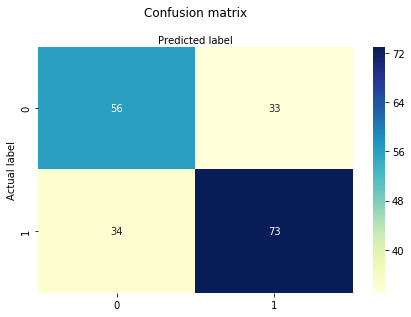

In [14]:
utils.display_confusion_matrix(y_test, y_pred)

In [15]:
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6581632653061225
Precision: 0.6886792452830188
Recall: 0.6822429906542056
Log loss=  0.5959930358524357


In [16]:
cross_val_scores = cross_val_score(rf_classifier, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7455081001472754


In [18]:
train_sizes, train_scores, test_scores = learning_curve(rf_classifier, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

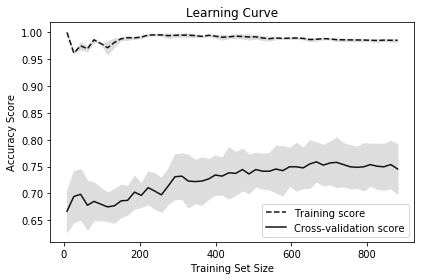

In [19]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
#param_grid = {
#    
#    "n_estimators": [500,750,1000,2000,3000],
#    "max_features":['sqrt'],
#    "criterion":['entropy'],
#    "min_samples_split": [2],
#    "min_samples_leaf":[2,5],
#    "max_depth": [10]
#}
#grid_search_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, cv=5, 
#                                 n_jobs =-1, scoring='accuracy')

#grid_search_model.fit(X_train, y_train)
#score = grid_search_model.score(X_train, y_train)
#print("Grid Search  Model Score= ", score)


In [ ]:
#grid_search_model.best_params_

#### Model Feature Optimization

In [20]:
model_stats = eliminate_features(rf_classifier, X,y)

Iteration=  0
least_important label=  top_conf_t
Iteration=  1
least_important label=  top_conf_o
Iteration=  2
least_important label=  delta_def_rebs_avg
Iteration=  3
least_important label=  delta_off_rebs_avg
Iteration=  4
least_important label=  delta_to_net_avg
Iteration=  5
least_important label=  delta_ft_att_avg
Iteration=  6
least_important label=  delta_margin_victory_avg
Iteration=  7
least_important label=  delta_fg_pct
Iteration=  8
least_important label=  delta_off_rating
Iteration=  9
least_important label=  delta_ft_pct
Iteration=  10
least_important label=  delta_seed
Iteration=  11
least_important label=  delta_rpi
Iteration=  12
least_important label=  delta_wol
Iteration=  13
least_important label=  delta_col
Iteration=  14
least_important label=  delta_dol
Iteration=  15
least_important label=  delta_sos
Iteration=  16
least_important label=  delta_mor
Iteration=  17
least_important label=  delta_wlk
Iteration=  18
least_important label=  delta_sag
Iteration=  19
l

In [21]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.6582 Cross Val= 0.7455  Log Loss= 0.5960
Accuracy= 0.6633 Cross Val= 0.7547  Log Loss= 0.5975
Accuracy= 0.6684 Cross Val= 0.7547  Log Loss= 0.6009
Accuracy= 0.6531 Cross Val= 0.7598  Log Loss= 0.5969
Accuracy= 0.6684 Cross Val= 0.7629  Log Loss= 0.5971
Accuracy= 0.6684 Cross Val= 0.7649  Log Loss= 0.6021
Accuracy= 0.6786 Cross Val= 0.7679  Log Loss= 0.5987
Accuracy= 0.6786 Cross Val= 0.7639  Log Loss= 0.6029
Accuracy= 0.6684 Cross Val= 0.7649  Log Loss= 0.5985
Accuracy= 0.6684 Cross Val= 0.7649  Log Loss= 0.5969
Accuracy= 0.6684 Cross Val= 0.7730  Log Loss= 0.6064
Accuracy= 0.6786 Cross Val= 0.7751  Log Loss= 0.6046
Accuracy= 0.6837 Cross Val= 0.7751  Log Loss= 0.5996
Accuracy= 0.6684 Cross Val= 0.7771  Log Loss= 0.6006
Accuracy= 0.6888 Cross Val= 0.7782  Log Loss= 0.5991
Accuracy= 0.6990 Cross Val= 0.7771  Log Loss= 0.6050
Accuracy= 0.6531 Cross Val= 0.7444  Log Loss= 0.6280
Accuracy= 0.6735 Cross Val= 0.7393  Log Loss= 0.6435
Accuracy= 0.6582 Cross Val= 0.7434  Log Loss= 

In [22]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_win_pct', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wlk', 'delta_rth', 'delta_pom', 'delta_dol', 'delta_mor']


In [23]:
X=X[model_features]

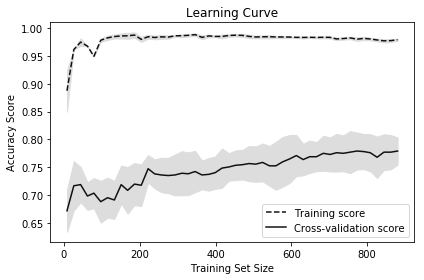

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
rf_classifier.fit(X_train, y_train)



train_sizes, train_scores, test_scores = learning_curve(rf_classifier, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Accuracy: 0.6887755102040817
Precision: 0.7211538461538461
Recall: 0.7009345794392523
Log loss=  0.5990531159875809
Cross Validation:  0.7781611613717652


array([[60, 29],
       [32, 75]], dtype=int64)

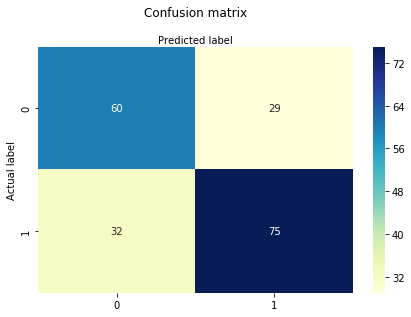

In [25]:
y_pred = rf_classifier.predict(X_test)
# save model stats
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))
cross_val_scores = cross_val_score(rf_classifier, X,y, cv=10, scoring='accuracy')
print("Cross Validation: ", cross_val_scores.mean())
utils.display_confusion_matrix(y_test, y_pred)

In [26]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, prediction_probabilities, X_test, y_test, y_pred)
missed_predictions

                                       Kansas                   Bucknell     Stat Supports Winner
Allow PPG                       65.00                              58.00         True  (L)
FT %                            69.50                              70.10         True  (H)
Takeaway Avg                     6.00                               7.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              9.00                             114.00        False  (L)
WLK                              7.00                              97.00        False  (L)
WOL                             10.00                              84.00        False  (L)
RTH                              7.00                             137.00        False  (L)
COL                              4.00                             102.00        False  (L)
POM                             12.00                             110.00        Fal

                                     Maryland              West Virginia     Stat Supports Winner
SAG                             27.00                              19.00         True  (L)
WLK                             27.00                              19.00         True  (L)
POM                             33.00                              25.00         True  (L)
MOR                             30.00                              29.00         True  (L)
Net Turnover Avg                 8.00                               2.00         True  (L)
SRS                             13.32                              15.12         True  (H)
SOS                              7.63                               9.29         True  (H)
PPG                             69.00                              72.00         True  (H)
Poss Avg                        72.11                              83.89         True  (H)
Off Rb Avg                       8.00                              16.00         Tr

RTH                             22.00                              38.00         True  (L)
COL                             13.00                              31.00         True  (L)
DOL                             13.00                              25.00         True  (L)
RPI                             12.00                              29.00         True  (L)
Poss Avg                        80.62                              75.43         True  (H)
FG %                            47.10                              46.90         True  (H)
FT ATT Avg                      21.00                              20.00         True  (H)
Takeaway Avg                     8.00                               6.00         True  (H)
Win %                           86.10                              80.00         True  (H)
POM                             39.00                              22.00        False  (L)
MOR                             22.00                              21.00        False  (L)

FT ATT Avg                      19.00                              23.00        False  (H)
FT %                            62.40                              74.30        False  (H)
Takeaway Avg                     7.00                               8.00        False  (H)
Margin Victory Avg              13.00                              13.00        False  (H)
Off Rating                      94.94                              99.23        False  (H)


Top Conference=  Notre Dame

 Winthrop Wins.

Supporting Stat Count= 5  out of 26  stats.



                                       Butler                 Louisville     Stat Supports Winner
Allow PPG                       60.00                              68.00         True  (L)
Turnover Avg                    10.00                              13.00         True  (L)
Net Turnover Avg                 4.00                               6.00         True  (L)
FG %                            47.50                              46.30       

season_t  round                    game_date  seed_t  \
128      2005     64  2005-03-18 00:00:00.0000000       3   
512      2011     32  2011-03-20 00:00:00.0000000       3   
178      2005     32  2005-03-19 00:00:00.0000000       2   
214      2006      8  2006-03-26 00:00:00.0000000       1   
656      2013     64  2013-03-22 00:00:00.0000000       2   
852      2016     64  2016-03-18 00:00:00.0000000       3   
816      2015     32  2015-03-21 00:00:00.0000000       1   
734      2014     16  2014-03-28 00:00:00.0000000       4   
778      2014     64  2014-03-21 00:00:00.0000000       3   
150      2005     64  2005-03-17 00:00:00.0000000       5   
106      2004      4  2004-04-03 00:00:00.0000000       1   
252      2006     32  2006-03-19 00:00:00.0000000       2   
752      2014     64  2014-03-20 00:00:00.0000000       5   
770      2014     32  2014-03-22 00:00:00.0000000       3   
346      2008     16  2008-03-27 00:00:00.0000000       2   
498      2010     32  2010-03-21 00:00:00.0000000       4   
684      2013     32  2013-03-23 00:00:00.0000000       1   
928      2017     32  2017-03-18 00:00:00.0000000       1   
960      2017     32  2017-03-19 00:00:00.0000000       2   
444      2009     32  2009-03-21 00:00:00.0000000       4   
388      2009     64  2009-03-20 00:00:00.0000000       8   
84       2004     64  2004-03-19 00:00:00.0000000      10   
842      2015     32  2015-03-22 00:00:00.0000000       4   
246      2006      8  2006-03-25 00:00:00.0000000       1   
290      2007     32  2007-03-17 00:00:00.0000000       4   
536      2011      4  2011-04-02 00:00:00.0000000       4   
516      2011     16  2011-03-25 00:00:00.0000000      10   
520      2011     64  2011-03-17 00:00:00.0000000      10   
480      2010     32  2010-03-21 00:00:00.0000000       4   
427      2009     32  2009-03-21 00:00:00.0000000       3   
..        ...    ...                          ...     ...   
209      2006     64  2006-03-16 00:00:00.0000000      12   
529      2011     32  2011-03-19 00:00:00.0000000       3   
579      2012     64  2012-03-16 00:00:00.0000000      10   
3        2003     64  2003-03-21 00:00:00.0000000      10   
653      2013     68  2013-03-19 00:00:00.0000000      16   
319      2007     64  2007-03-16 00:00:00.0000000       9   
905      2016     64  2016-03-17 00:00:00.0000000       9   
847      2016     64  2016-03-18 00:00:00.0000000       6   
593      2012      8  2012-03-24 00:00:00.0000000       4   
623      2012      8  2012-03-24 00:00:00.0000000       2   
397      2009     16  2009-03-26 00:00:00.0000000       3   
337      2008     64  2008-03-21 00:00:00.0000000       9   
665      2013     64  2013-03-21 00:00:00.0000000       6   
123      2004     32  2004-03-20 00:00:00.0000000       5   
735      2014      8  2014-03-30 00:00:00.0000000       8   
659      2013     64  2013-03-22 00:00:00.0000000      12   
749      2014     32  2014-03-23 00:00:00.0000000      10   
491      2010     16  2010-03-25 00:00:00.0000000       5   
921      2017     64  2017-03-17 00:00:00.0000000      11   
789      2015     68  2015-03-17 00:00:00.0000000      11   
419      2009     64  2009-03-20 00:00:00.0000000      12   
249      2006     32  2006-03-19 00:00:00.0000000      13   
507      2010     32  2010-03-20 00:00:00.0000000      10   
557      2011     64  2011-03-18 00:00:00.0000000       8   
973      2017     64  2017-03-16 00:00:00.0000000      12   
271      2007     64  2007-03-16 00:00:00.0000000      11   
23       2003     32  2003-03-23 00:00:00.0000000      12   
201      2006     64  2006-03-17 00:00:00.0000000      10   
583      2012     64  2012-03-16 00:00:00.0000000      15   
607      2012     64  2012-03-16 00:00:00.0000000      15   

                   team_t                             team_id_t  win_pts  \
128                Kansas  fae4855b-1b64-4b40-a632-9ed345e1e952       64   
512                Purdue  12d7f888-675b-459f-9099-a38f771d8a95       

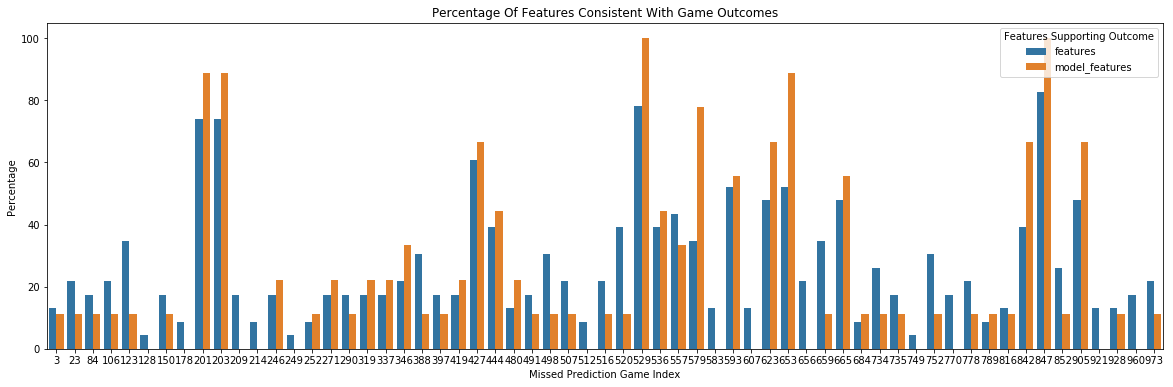

In [27]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

### Run Model Against 2018 Tournament

In [28]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year][model_features]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 9)

array([[21, 12],
       [ 8, 26]], dtype=int64)

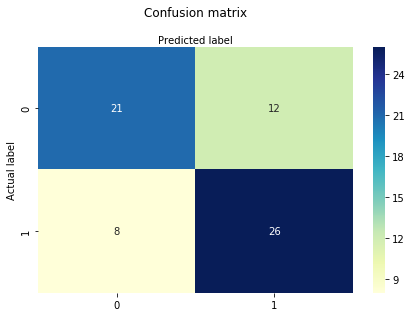

In [29]:
y_pred_season = rf_classifier.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)